import torch
import torch.nn as nn

triplet_loss = nn.TripletMarginLoss(margin=1.0, p=2)
anchor = torch.randn(100, 128, requires_grad=True)
positive = torch.randn(100, 128, requires_grad=True)
negative = torch.randn(100, 128, requires_grad=True)
output = triplet_loss(anchor, positive, negative)
output.backward()

from decord import VideoReader, cpu
import numpy as np

from transformers import VideoMAEImageProcessor, VideoMAEModel
from huggingface_hub import hf_hub_download


def sample_frame_indices(clip_len, frame_sample_rate, seg_len):
    converted_len = int(clip_len * frame_sample_rate)
    end_idx = np.random.randint(converted_len, seg_len)
    start_idx = end_idx - converted_len
    indices = np.linspace(start_idx, end_idx, num=clip_len)
    indices = np.clip(indices, start_idx, end_idx - 1).astype(np.int64)
    return indices




# video clip consists of 300 frames (10 seconds at 30 FPS)
file_path = hf_hub_download(
    repo_id="nielsr/video-demo", filename="eating_spaghetti.mp4", repo_type="dataset"
)
videoreader = VideoReader(file_path, num_threads=1, ctx=cpu(0))

# sample 16 frames
videoreader.seek(0)
indices = sample_frame_indices(clip_len=16, frame_sample_rate=4, seg_len=len(videoreader))
video = videoreader.get_batch(indices).asnumpy()


In [1]:
import numpy as np

from transformers import VideoMAEImageProcessor, VideoMAEModel

2022-12-28 18:32:26.540159: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-12-28 18:32:27.510794: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/nvidia/lib:/usr/local/nvidia/lib64
2022-12-28 18:32:27.510881: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/nvidia/lib:/usr/local/nvidia/lib64
2022-12-28 18:32:27.510888: W tensorfl

In [2]:

from transformers import VideoMAEImageProcessor, VideoMAEForVideoClassification

In [3]:
#model = VideoMAEForVideoClassification.from_pretrained("MCG-NJU/videomae-base-finetuned-kinetics")


In [4]:
import torch
import torch.nn as nn

class my_model(nn.Module):
    def __init__(self):
        super().__init__()#"MCG-NJU/videomae-base")
        self.model = VideoMAEModel.from_pretrained("MCG-NJU/videomae-base")
        self.average = nn.AdaptiveAvgPool1d(1) 
    def forward(self, inputs):
        
        x = self.model(inputs).last_hidden_state
        #print('1:',x.shape)
        x = x.permute(0,2,1)
        #print('2:',x.shape)
        x = self.average(x).squeeze()
        #print('3:',x.shape)
        return x


In [5]:

image_processor = VideoMAEImageProcessor.from_pretrained("MCG-NJU/videomae-base")
model = my_model()

#model = VideoMAEModel.from_pretrained("MCG-NJU/videomae-base")


#model = nn.Sequential(
#    model,
#    nn.functional.avg_pool1d()
#)
# prepare video for the model
#inputs = image_processor(list(video), return_tensors="pt")

# forward pass
#outputs = model(**inputs)
#last_hidden_states = outputs.last_hidden_state
#list(last_hidden_states.shape)

Some weights of the model checkpoint at MCG-NJU/videomae-base were not used when initializing VideoMAEModel: ['decoder.decoder_layers.2.output.dense.weight', 'decoder.decoder_layers.2.attention.attention.value.weight', 'decoder.decoder_layers.3.layernorm_before.weight', 'decoder.decoder_layers.1.attention.attention.q_bias', 'decoder.head.bias', 'decoder.decoder_layers.0.attention.attention.query.weight', 'decoder.decoder_layers.2.attention.attention.key.weight', 'decoder.decoder_layers.3.attention.attention.q_bias', 'decoder.decoder_layers.0.intermediate.dense.weight', 'decoder.decoder_layers.0.attention.output.dense.bias', 'decoder.decoder_layers.0.output.dense.bias', 'decoder.decoder_layers.1.attention.attention.value.weight', 'decoder.decoder_layers.2.layernorm_after.bias', 'decoder.decoder_layers.2.attention.attention.v_bias', 'decoder.decoder_layers.2.attention.attention.q_bias', 'decoder.decoder_layers.2.output.dense.bias', 'decoder.decoder_layers.3.intermediate.dense.bias', 'dec

In [ ]:
#inputs['pixel_values'].shape

In [ ]:
#import torch

In [ ]:
#inputs = torch.randn(1,16,3, 224, 224, requires_grad=False)

In [ ]:

#outputs = model(inputs)

In [ ]:
#outputs.last_hidden_state

model

In [6]:
model_ckpt = "MCG-NJU/videomae-base"
batch_size = 8

In [7]:
from transformers import VideoMAEFeatureExtractor

In [17]:
#dataset_root_path = '/data/ZHO/formats/ucf101_letters_only_avi/'
dataset_root_path = '/projects/ZHO/formats/ucf101_letters_only/'

feature_extractor = VideoMAEFeatureExtractor.from_pretrained(model_ckpt)
 

/usr/local/lib/python3.8/dist-packages/transformers/models/videomae/feature_extraction_videomae.py:28: FutureWarning: The class VideoMAEFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use VideoMAEImageProcessor instead.
  warnings.warn(


In [18]:
import pytorchvideo.data

from pytorchvideo.transforms import (
    ApplyTransformToKey,
    Normalize,
    RandomShortSideScale,
    RemoveKey,
    ShortSideScale,
    UniformTemporalSubsample,
)

from torchvision.transforms import (
    Compose,
    Lambda,
    RandomCrop,
    RandomHorizontalFlip,
    Resize,
)

In [19]:
import os

mean = feature_extractor.image_mean
std = feature_extractor.image_std
resize_to = feature_extractor.size['shortest_edge']
print(resize_to)
num_frames_to_sample = 16#model.config.num_frames
sample_rate = 4
fps = 30
#clip_duration = num_frames_to_sample * sample_rate / fps
clip_duration =10
print(clip_duration)

# Training dataset transformations.
train_transform = Compose(
    [
        ApplyTransformToKey(
            key="video",
            transform=Compose(
                [
                    UniformTemporalSubsample(num_frames_to_sample),
                    Lambda(lambda x: x / 255.0),
                    Normalize(mean, std),
                    #RandomShortSideScale(min_size=256, max_size=320),
                    Resize((resize_to,resize_to)),
                    #RandomHorizontalFlip(p=0.5),
                ]
            ),
        ),
    ]
)
# Training dataset.
train_dataset = pytorchvideo.data.labeled_video_dataset(
    data_path=os.path.join(dataset_root_path, "train"),
    #data_path = os.path.join(dataset_root_path,'annotations','trainlist01.txt'),
    clip_sampler=pytorchvideo.data.make_clip_sampler("random", clip_duration),
    decode_audio=False,
    transform=train_transform,
)

# Validation and evaluation datasets' transformations.
val_transform = Compose(
    [
        ApplyTransformToKey(
            key="video",
            transform=Compose(
                [
                    UniformTemporalSubsample(num_frames_to_sample),
                    Lambda(lambda x: x / 255.0),
                    Normalize(mean, std),
                    Resize((resize_to, resize_to)),
                ]
            ),
        ),
    ]
)



224
10


In [20]:
'''
# Validation and evaluation datasets.
val_dataset = pytorchvideo.data.Ucf101(
    data_path=os.path.join(dataset_root_path, "val"),
    clip_sampler=pytorchvideo.data.make_clip_sampler("uniform", clip_duration),
    decode_audio=False,
    transform=val_transform,
)
test_dataset = pytorchvideo.data.Ucf101(
    data_path=os.path.join(dataset_root_path, "test"),
    clip_sampler=pytorchvideo.data.make_clip_sampler("uniform", clip_duration),
    decode_audio=False,
    transform=val_transform,
)
'''

'\n# Validation and evaluation datasets.\nval_dataset = pytorchvideo.data.Ucf101(\n    data_path=os.path.join(dataset_root_path, "val"),\n    clip_sampler=pytorchvideo.data.make_clip_sampler("uniform", clip_duration),\n    decode_audio=False,\n    transform=val_transform,\n)\ntest_dataset = pytorchvideo.data.Ucf101(\n    data_path=os.path.join(dataset_root_path, "test"),\n    clip_sampler=pytorchvideo.data.make_clip_sampler("uniform", clip_duration),\n    decode_audio=False,\n    transform=val_transform,\n)\n'

In [21]:
# Validation and evaluation datasets.
val_dataset = pytorchvideo.data.Kinetics(
    data_path=os.path.join(dataset_root_path, "val"),
    clip_sampler=pytorchvideo.data.make_clip_sampler("uniform", clip_duration),
    decode_audio=False,
    transform=val_transform,
)
test_dataset = pytorchvideo.data.Kinetics(
    data_path=os.path.join(dataset_root_path, "test"),
    clip_sampler=pytorchvideo.data.make_clip_sampler("uniform", clip_duration),
    decode_audio=False,
    transform=val_transform,
)

In [22]:
from torch.utils.data import DataLoader


In [23]:
batch_size = 16

In [24]:

#train_dataset = pytorchvideo.data.Ucf101(data_path=dataset_root_path, transform=train_transform, clip_sampler=sampler)
# dataset = UCF101(root=img_path, annotation_path=annotation_path, frames_per_clip=16, transform=transform)


train_dataloader = DataLoader(train_dataset,batch_size=16,num_workers=1)
 

In [25]:
#iterator=iter(train_dataloader)

In [26]:
import time

In [27]:
train_dataset.num_videos


64

import torch.functional  as F

import torch.nn as nn

class Identity(nn.Module):
    def __init__(self):
        super(Identity, self).__init__()
        
    def forward(self, x):
        return x


In [24]:
#model.classifier = Identity()

In [28]:
model.cuda()

my_model(
  (model): VideoMAEModel(
    (embeddings): VideoMAEEmbeddings(
      (patch_embeddings): VideoMAEPatchEmbeddings(
        (projection): Conv3d(3, 768, kernel_size=(2, 16, 16), stride=(2, 16, 16))
      )
    )
    (encoder): VideoMAEEncoder(
      (layer): ModuleList(
        (0): VideoMAELayer(
          (attention): VideoMAEAttention(
            (attention): VideoMAESelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=False)
              (key): Linear(in_features=768, out_features=768, bias=False)
              (value): Linear(in_features=768, out_features=768, bias=False)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): VideoMAESelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): VideoMAEIntermediate(
            (dense): Linear(in_features=768, out_features

In [31]:
#model = torch.load('/projects/models/model_100_epoch.pth')
#parallel_net = torch.load('/projects/models/model_100_epoch.pth')

import torch

In [29]:
parallel_net = nn.DataParallel(model, device_ids = [0,1])

In [30]:
from pytorch_metric_learning import miners, losses
miner = miners.MultiSimilarityMiner()
loss_func = losses.TripletMarginLoss()



In [31]:
from torch.optim import AdamW
optimizer = AdamW(model.parameters(),lr =0.001)

In [32]:
# Training dataset.
test_dataset = pytorchvideo.data.labeled_video_dataset(
    data_path=os.path.join(dataset_root_path, "test"),
    #data_path = os.path.join(dataset_root_path,'annotations','trainlist01.txt'),
    clip_sampler=pytorchvideo.data.make_clip_sampler("uniform", clip_duration),
    decode_audio=False,
    transform=val_transform,
)
test_dataloader = DataLoader(test_dataset,batch_size=16,num_workers=8)  

In [42]:
config = 4# to be read from the file

In [35]:
import numpy as np
def run_test():
    outputs = []
    labels_list = []
    with torch.no_grad():
        for i,j in enumerate(test_dataloader):
            input = j['video'].permute(0,2,1,3,4).cuda()
            embeddings = parallel_net(input)#.logits
            print('test_shape:',embeddings.shape)

            labels = j['label'].cuda()
            hard_pairs= miner(embeddings,labels)
            loss = loss_func(embeddings, labels , hard_pairs)
            print('test:',loss.item())


            outputs.append(embeddings.cpu().numpy())
            labels_list.append(j['label'].numpy())
    return np.vstack(outputs), np.concatenate(labels_list)

In [45]:
from sklearn.decomposition import PCA
import numpy as np


def run_pca(embeddings, dim=3):
    pca = PCA(n_components=dim)
    temp = embeddings-np.mean(embeddings, axis=0)
    a = pca.fit_transform(temp)
    return a


In [ ]:
import matplotlib.pyplot as plt
import random


def plot_embeddings(a, labels_new, epoch, config):
    hexadecimal_alphabets = '0123456789ABCDEF'
    number_of_colors = 32
    color = ["#" + ''.join([random.choice(hexadecimal_alphabets) for j in
                            range(6)]) for i in range(number_of_colors)]

    fig = plt.figure(figsize=(12, 12))
    ax = fig.add_subplot(projection='3d')
    for i in range(len(labels_new)):
        ax.scatter(a[i][0], a[i][1], a[i][2], c=color[labels_new[i]])
        ax.text(a[i][0], a[i][1], a[i][2], labels_new[i])
    plt.savefig('/projects/plots/exp'+str(config) +
                '/embeddings_'+str(epoch)+'.png')
    plt.show()


In [36]:
dim =3

In [ ]:
#'video_name'
#'video_index'
#'clip_index'
#'aug_index'
#'label'
for epoch in range(100):
    outputs = []
    labels_list = []
    
    print('epoch:',epoch)
    for i,j in enumerate(train_dataloader):
        #print(j['video'].shape,j['label'].shape)
        #start = time.time()
        input = j['video'].permute(0,2,1,3,4).cuda()
        #print(input.shape)
        #end = time.time()
        #print(end-start)
        #print(model(input).last_hidden_state.shape, j['label'])
        #print(j['label'])    
        #model.layernorm()
        labels = j['label'].cuda()
        print(input.dtype,labels.dtype)

        embeddings = parallel_net(input)#.logits
        #print(embeddings.shape)

        hard_pairs= miner(embeddings,labels)
        loss = loss_func(embeddings, labels , hard_pairs)
        loss.backward()
        print(loss.item())
        optimizer.step()
        optimizer.zero_grad()
        
        outputs.append(embeddings.detach().cpu().numpy())
        labels_list.append(j['label'].detach().numpy())

    embeddings, labels = run_test()
    outputs.append(embeddings)
    labels_list.append(labels)
    labels_new = np.concatenate(labels_list).squeeze()
    a = run_pca(np.vstack(outputs), dim)
    plot_embeddings(a,labels_new,epoch,config)
    #outputs.append(y.detach().cpu().numpy())
    #labels_list.append(j['label'].numpy())

In [36]:
torch.save(model.state_dict(), '/projects/models/model_100_epoch.pth')

In [ ]:
for epoch in range(100):
    outputs = []
    labels_list = []
    
    print('epoch:',epoch)
    for i,j in enumerate(train_dataloader):
        #optimizer.zero_grad()
        #print(j['video'].shape,j['label'].shape)
        #start = time.time()
        input = j['video'].permute(0,2,1,3,4).cuda()
        print(input.shape)
        #end = time.time()
        #print(end-start)
        #print(model(input).last_hidden_state.shape, j['label'])
        #print(j['label'])    
        #model.layernorm()
        
        embeddings = parallel_net(input)#.logits
        #print(embeddings.shape)
        labels = j['label'].cuda()
        print('labels:', labels)
        hard_pairs= miner(embeddings,labels)
        print('hard:',hard_pairs)
        loss = loss_func(embeddings, labels , hard_pairs)
        #loss.backward()
        print('loss:',loss.item())
        #optimizer.step()
        
        #outputs.append(embeddings.detach().cpu().numpy())
        #labels_list.append(j['label'].detach().numpy())

    #embeddings, labels = run_test()
    #outputs.append(embeddings)
    #labels_list.append(labels)
    #labels_new = np.concatenate(labels_list).squeeze()
    #a = run_pca(np.vstack(outputs), dim)
    #plot_embeddings(a,labels_new,epoch,config)
    #outputs.append(y.detach().cpu().numpy())
    #labels_list.append(j['label'].numpy())

In [75]:
outputs = []
labels_list = []
with torch.no_grad():
    for i,j in enumerate(train_dataloader):
        #optimizer.zero_grad()
        #print(j['video'].shape,j['label'].shape)
        #start = time.time()
        input = j['video'].permute(0,2,1,3,4).cuda()
        #print(input.shape)
        #end = time.time()
        #print(end-start)
        #print(model(input).last_hidden_state.shape, j['label'])
        #print(j['label'])    
        #model.layernorm()
        embeddings = parallel_net(input)#.logits
        print(embeddings.shape)
        labels = j['label']

        outputs.append(embeddings.cpu().numpy())
        labels_list.append(j['label'].numpy())


torch.Size([16, 768])
torch.Size([16, 768])
torch.Size([16, 768])
torch.Size([16, 768])


In [77]:
eee = np.vstack(outputs)#,axis=-1)#.reshape(64,768)
labels_new = np.concatenate(labels_list).squeeze()

In [58]:
labels_new.shape

(96,)

In [59]:
eee.shape

(96, 768)

In [60]:
print(eee.shape)
print(labels_new.shape)

(96, 768)
(96,)


In [61]:
labels

tensor([26, 17, 28, 13])

In [78]:
from sklearn.decomposition import PCA


In [81]:
pca = PCA(n_components = 3)
temp=eee-np.mean(eee,axis=0)
a=pca.fit_transform(temp)

In [46]:
print(a.shape)

(64, 2)


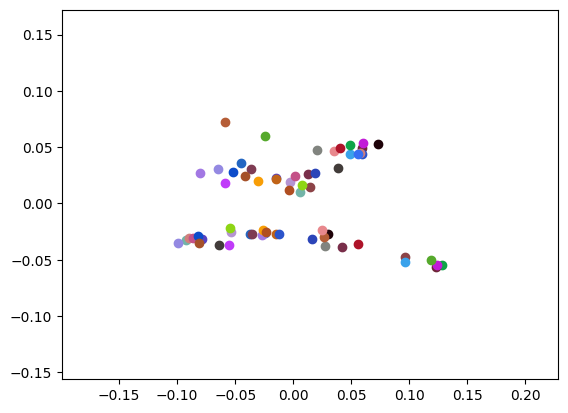

In [80]:
# Сонгож авсан үгнүүдээ хавтгайд байгуулж харъя
import matplotlib.pyplot as plt
import random
hexadecimal_alphabets = '0123456789ABCDEF'
number_of_colors = 32
color = ["#" + ''.join([random.choice(hexadecimal_alphabets) for j in
range(6)]) for i in range(number_of_colors)]
plt.figure()

for i in range(len(labels_new)):
    #print(a[i][0],a[i][1],color[labels_new[i]])
    plt.scatter(a[i][0],a[i][1],c=color[labels_new[i]])
    
plt.xlim((np.min(a[:,0])-0.1, np.max(a[:,0])+0.1))
plt.ylim((np.min(a[:,1])-0.1, np.max(a[:,1])+0.1))
plt.show()

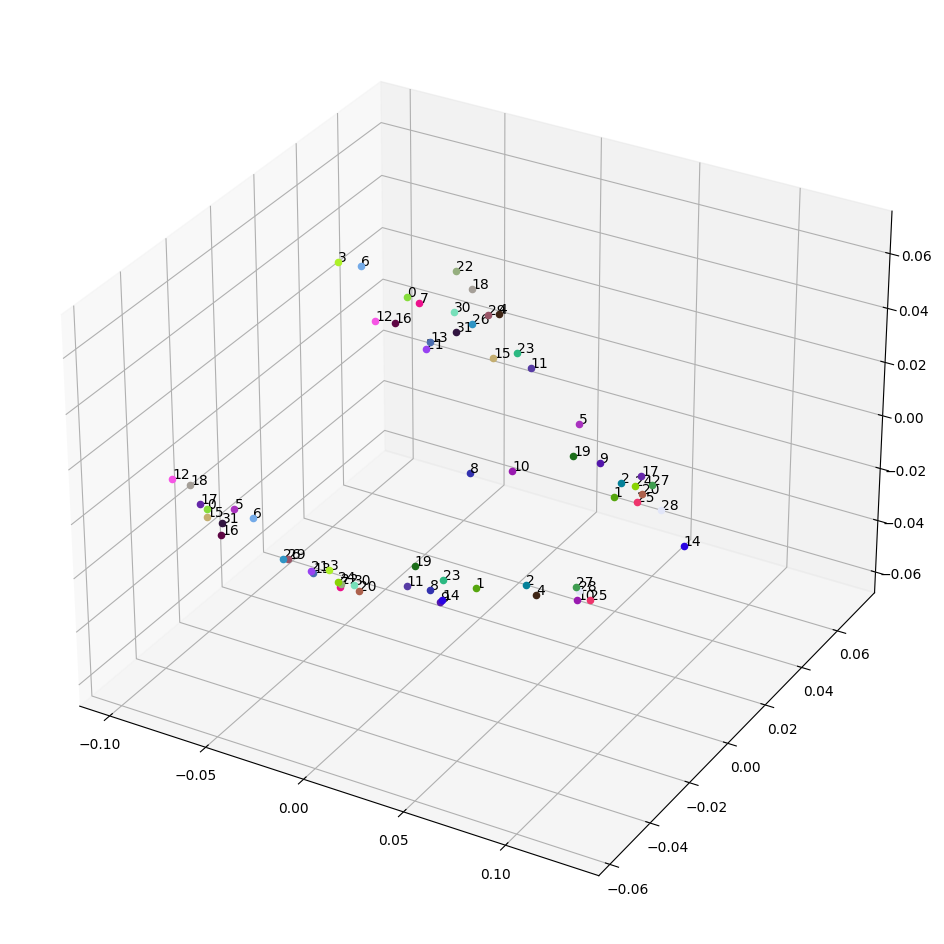

In [84]:
hexadecimal_alphabets = '0123456789ABCDEF'
number_of_colors = 32
color = ["#" + ''.join([random.choice(hexadecimal_alphabets) for j in
range(6)]) for i in range(number_of_colors)]

fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(projection='3d')
for i in range(len(labels_new)):
    ax.scatter(a[i][0], a[i][1],a[i][2],c= color[labels_new[i]])
    ax.text(a[i][0],a[i][1],a[i][2],labels_new[i])
plt.show()

In [ ]:
import torch.nn as nn


In [ ]:
import fiftyone as fo

In [ ]:
from decord import VideoReader, cpu
import torch
import numpy as np

from transformers import VideoMAEImageProcessor, VideoMAEForVideoClassification
from huggingface_hub import hf_hub_download

np.random.seed(0)


def sample_frame_indices(clip_len, frame_sample_rate, seg_len):
    converted_len = int(clip_len * frame_sample_rate)
    end_idx = np.random.randint(converted_len, seg_len)
    start_idx = end_idx - converted_len
    indices = np.linspace(start_idx, end_idx, num=clip_len)
    indices = np.clip(indices, start_idx, end_idx - 1).astype(np.int64)
    return indices


# video clip consists of 300 frames (10 seconds at 30 FPS)
file_path = hf_hub_download(
    repo_id="nielsr/video-demo", filename="eating_spaghetti.mp4", repo_type="dataset"
)
videoreader = VideoReader(file_path, num_threads=1, ctx=cpu(0))

# sample 16 frames
videoreader.seek(0)
indices = sample_frame_indices(clip_len=16, frame_sample_rate=4, seg_len=len(videoreader))
video = videoreader.get_batch(indices).asnumpy()

image_processor = VideoMAEImageProcessor.from_pretrained("MCG-NJU/videomae-base-finetuned-kinetics")
model = VideoMAEForVideoClassification.from_pretrained("MCG-NJU/videomae-base-finetuned-kinetics")

inputs = image_processor(list(video), return_tensors="pt")

with torch.no_grad():
    outputs = model(**inputs)
    logits = outputs.logits

# model predicts one of the 400 Kinetics-400 classes
predicted_label = logits.argmax(-1).item()
print(model.config.id2label[predicted_label])

In [27]:
!pip install torchinfo

In [28]:
from torchinfo import summary
#model.to('cuda') #always need to send the model to cuda before running this command
summary(model,input_size = (1,16,3,224,224))

Layer (type:depth-idx)                                       Output Shape              Param #
my_model                                                     [1, 1568, 768]            --
├─VideoMAEModel: 1-1                                         [1, 1568, 768]            --
│    └─VideoMAEEmbeddings: 2-1                               [1, 1568, 768]            --
│    │    └─VideoMAEPatchEmbeddings: 3-1                     [1, 1568, 768]            1,180,416
│    └─VideoMAEEncoder: 2-2                                  [1, 1568, 768]            --
│    │    └─ModuleList: 3-2                                  --                        85,045,248
│    └─LayerNorm: 2-3                                        [1, 1568, 768]            1,536
Total params: 86,227,200
Trainable params: 86,227,200
Non-trainable params: 0
Total mult-adds (G): 1.91
Input size (MB): 9.63
Forward/backward pass size (MB): 944.11
Params size (MB): 259.90
Estimated Total Size (MB): 1213.65

In [ ]:
model

In [ ]:
#from torchsummary import summary
from torchinfo import summary
#model.to('cuda') #always need to send the model to cuda before running this command
summary(model,input_size = (1,16,3,224,224))

In [ ]:
import torch.nn as nn
# NLP Example
batch, sentence_length, embedding_dim = 20, 5, 10
embedding = torch.randn(batch, sentence_length, embedding_dim)
layer_norm = nn.LayerNorm(embedding_dim)
# Activate module
layer_norm(embedding)
# Image Example
N, C, H, W = 20, 5, 10, 10
input = torch.randn(N, C, H, W)
# Normalize over the last three dimensions (i.e. the channel and spatial dimensions)
# as shown in the image below
layer_norm = nn.LayerNorm([C, H, W])
output = layer_norm(input)

output.shape

In [1]:

from torch.utils.tensorboard import SummaryWriter

writer = SummaryWriter('runs/VideoMAE')

2022-12-20 11:44:12.461416: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-12-20 11:44:13.695112: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/nvidia/lib:/usr/local/nvidia/lib64
2022-12-20 11:44:13.695218: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/nvidia/lib:/usr/local/nvidia/lib64
2022-12-20 11:44:13.695227: W tensorfl

In [ ]:
input = torch.rand([1,16,3,224,224])

In [ ]:
dataiter = iter(train_dataloader)
a = next(dataiter)

In [ ]:

print(a)

In [2]:
writer.add_graph(model, a['video'].permute(0,2,1,3,4))
writer.close()

NameError: name 'model' is not defined

In [ ]:

from torchviz import make_dot

make_dot(model)

In [ ]:
yhat = model(a['video'].permute(0,2,1,3,4))

In [ ]:
make_dot(yhat, params=dict(model.named_parameters()))

In [ ]:
from collections import namedtuple
from typing import Any

import torch


# pylint: disable = abstract-method
class ModelWrapper(torch.nn.Module):
    """
    Wrapper class for model with dict/list rvalues.
    """

    def __init__(self, model: torch.nn.Module) -> None:
        """
        Init call.
        """
        super().__init__()
        self.model = model

    def forward(self, input_x: torch.Tensor) -> Any:
        """
        Wrap forward call.
        """
        data = self.model(input_x)

        if isinstance(data, dict):
            data_named_tuple = namedtuple("ModelEndpoints", sorted(data.keys()))  # type: ignore
            data = data_named_tuple(**data)  # type: ignore

        elif isinstance(data, list):
            data = tuple(data)

        return data

In [ ]:
model_wrapper = ModelWrapper(model)
writer.add_graph(model_wrapper,  a['video'].permute(0,2,1,3,4))